In [1]:
import IPython.display as ipd 
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout
from sklearn import metrics


from sklearn.metrics.cluster import contingency_matrix



In [2]:
import pandas as pd
import os
audio_dataset_path = '../UrbanSound8K/audio/'
metadata = pd.read_csv('../UrbanSound8K/metadata/UrbanSound8K.csv')

metadata.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [43]:
classe =  np.unique(metadata['class'])

In [56]:
def feature_extractor(file):
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
    mfccs_feature = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_feature = np.mean(mfccs_feature.T,axis=0)
    return mfccs_scaled_feature

In [57]:
extracted_features = []
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))
    final_class_labels = row['class']
    fold = row['fold']
    data= feature_extractor(file_name)
    extracted_features.append([data,final_class_labels,fold])



3554it [04:44, 12.48it/s]/home/maxence/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8324it [11:04, 17.43it/s]/home/maxence/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/home/maxence/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8731it [11:35, 12.55it/s]


In [61]:
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class','fold'])
extracted_features_df.head()



,feature,class,fold
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark,5
1,"[-424.68677, 110.56227, -54.14824, 62.01074, -...",children_playing,5
2,"[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing,5
3,"[-414.55377, 102.896904, -36.66495, 54.180405,...",children_playing,5
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing,5


In [59]:
extracted_features_df.to_pickle("us8k_df_mfcc_2.pkl")

In [6]:
x = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [7]:
x.shape

(8731, 40)

In [8]:
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


In [9]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, yy, test_size=0.2, random_state = 42,stratify = yy )
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state = 42, stratify = y_test)



In [10]:
num_labels = yy.shape[1]
filter_size = 2

In [11]:
# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

In [14]:
# Calculate pre-training accuracy 
score = model.evaluate(x_train, y_train, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)



Pre-training accuracy: 8.4479%


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 8.2889 - accuracy: 0.1936 - val_loss: 2.0940 - val_accuracy: 0.2800

Epoch 00001: val_loss improved from inf to 2.09397, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
219/219 [==============================] - 0s 993us/step - loss: 2.2292 - accuracy: 0.2414 - val_loss: 1.9446 - val_accuracy: 0.3486

Epoch 00002: val_loss improved from 2.09397 to 1.94460, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 3/100
219/219 [==============================] - 0s 986us/step - loss: 2.0230 - accuracy: 0.2771 - val_loss: 1.7613 - val_accuracy: 0.4200

Epoch 00003: val_loss improved from 1.94460 to 1.76132, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 1.8914 - accuracy: 0.3232 - val_loss: 1.6699 - val_accuracy: 0.4457

Epoch 00004: val_loss improved from 1.76132 to 1.66990, saving model to saved_models/

In [16]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", score[1])



Train Accuracy:  0.9296964406967163
Test Accuracy:  0.8818897604942322


In [17]:
y_pred = model.predict_classes(x_test)

/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [35]:
y_test_encode =[]
for i in range(len(y_test)):
    y_test_encode.append(np.argmax(y_test[i]))


In [38]:
mat = contingency_matrix(y_test_encode,y_pred)

In [45]:
classe

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [51]:
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music']
classe

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

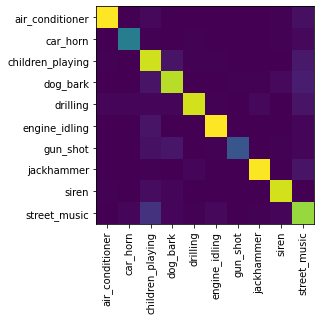

In [54]:
from matplotlib import pyplot as plt
plt.imshow(mat)
plt.xticks(np.arange(10), labels, rotation ='vertical')
plt.yticks(np.arange(10), labels, rotation ='horizontal')
plt.show()

In [25]:
def extract_feature(file_name):

    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    print("Classe")
        

    return np.array([mfccsscaled])

In [26]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("Classe prédite:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )



In [31]:
fname = '/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold1/21684-9-0-7.wav'
print_prediction(fname)
ipd.Audio(fname)



The predicted class is: street_music 

air_conditioner 		 :  0.02962172776460647583007812500000
car_horn 		 :  0.00045521277934312820434570312500
children_playing 		 :  0.33056771755218505859375000000000
dog_bark 		 :  0.00938011892139911651611328125000
drilling 		 :  0.00034197446075268089771270751953
engine_idling 		 :  0.06389820575714111328125000000000
gun_shot 		 :  0.00039135129190981388092041015625
jackhammer 		 :  0.00020365907403174787759780883789
siren 		 :  0.00181522569619119167327880859375
street_music 		 :  0.56332480907440185546875000000000


/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [32]:
fname = '/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold1/7383-3-0-0.wav'
print_prediction(fname)
ipd.Audio(fname)

The predicted class is: dog_bark 

air_conditioner 		 :  0.00000000000735225942627426576337
car_horn 		 :  0.00000000196267002650074573466554
children_playing 		 :  0.00000099673752629314549267292023
dog_bark 		 :  0.99972313642501831054687500000000
drilling 		 :  0.00000041007695017469814047217369
engine_idling 		 :  0.00000000000902770046218304145214
gun_shot 		 :  0.00004107885979465208947658538818
jackhammer 		 :  0.00000000000000000017247623085465
siren 		 :  0.00000124778159715788206085562706
street_music 		 :  0.00023320237232837826013565063477


In [33]:
fname = '/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold7/518-4-0-0.wav'
print_prediction(fname)
ipd.Audio(fname)

The predicted class is: drilling 

air_conditioner 		 :  0.00156359001994132995605468750000
car_horn 		 :  0.00871474388986825942993164062500
children_playing 		 :  0.02392831258475780487060546875000
dog_bark 		 :  0.01053502596914768218994140625000
drilling 		 :  0.51013606786727905273437500000000
engine_idling 		 :  0.00230906065553426742553710937500
gun_shot 		 :  0.00562745332717895507812500000000
jackhammer 		 :  0.06171460449695587158203125000000
siren 		 :  0.00030066052568145096302032470703
street_music 		 :  0.37517046928405761718750000000000


/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [36]:
fname = '/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold1/24074-1-0-12.wav'
print_prediction(fname)
ipd.Audio(fname)

The predicted class is: car_horn 

air_conditioner 		 :  0.00000000000000000000000000000000
car_horn 		 :  1.00000000000000000000000000000000
children_playing 		 :  0.00000000000000000000000000000000
dog_bark 		 :  0.00000000000000000000000000000000
drilling 		 :  0.00000000000000000000000000000000
engine_idling 		 :  0.00000000000000000000000000000000
gun_shot 		 :  0.00000000000000000000000000000000
jackhammer 		 :  0.00000000000000000000000000000000
siren 		 :  0.00000000000000000000000000000000
street_music 		 :  0.00000000000000000000000000000000


/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/home/maxence/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
